In [96]:
%gui tk
%matplotlib inline

import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
from glob import glob
# from skimage.io import imread
import PIL.Image
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [97]:
#initialize tkinter stuff
root = tk.Tk()
root.withdraw()

''

In [98]:
# Create a dataframe for images and coordinates
data_dir = os.path.normpath(filedialog.askdirectory())
all_images = glob(os.path.join(data_dir, '*', '*.tif'))
all_info = glob(os.path.join(data_dir, '*', '*.txt'))
img_df = pd.DataFrame({'img_path': all_images, 'info_path': all_info})
img_id = lambda in_path: in_path.split('\\')[-2][-6:]
img_df['ImageID'] = img_df['img_path'].map(img_id)

In [99]:
# define regular expressions to get coordinates
regexp_x = re.compile("x = ([0-9.]*),")
regexp_y = re.compile("y = ([0-9.]*)\n")

In [100]:
# function to read coordinates from text file
def read_and_parse_coordinates(info_file):
    file = open(info_file, "r")
    lines = file.readlines()
    x = []
    y = []
    for line in lines:
        xi = regexp_x.search(line)
        if xi:
            x.append(xi.group(1))
            y.append(regexp_y.search(line).group(1))
    file.close()
    return np.array([np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)])


In [101]:
# function to read images from files
def load_image(img_file):
    image = np.array(PIL.Image.open(img_file), dtype = np.uint8)
#     image = imread(img_file)
    image = np.stack([image,image,image], 2)
    return image

In [102]:
#read coordinates
img_df['x_y_coordinates'] = img_df['info_path'].map(read_and_parse_coordinates)
#read images
img_df['images'] = img_df['img_path'].map(load_image)

In [103]:
# drop last row from dataframe for now because it's a big image
img_df = img_df[:-1]

In [104]:
img_df.sample(2)


,img_path,info_path,ImageID,x_y_coordinates,images
198,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,000199,"[[61.0, 93.0, 35.0, 76.0], [12.0, 32.0, 77.0, ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1058,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,001059,"[[80.0, 69.0, 127.0], [96.0, 65.0, 111.0]]","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


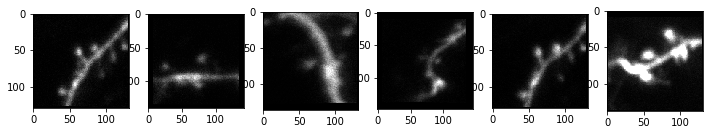

In [105]:
#Show a few sample images
n_img = 6
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images'].sample(n_img), range(6)):
    m_axs[ax_ind].imshow(img)

plt.show(fig)

In [106]:
#show example set of coordinates
img_df['x_y_coordinates'].sample(2)


1194    [[76.0, 80.0, 64.0, 77.0, 86.0, 124.0, 114.0, ...
604             [[66.0, 116.0, 27.0], [72.0, 32.0, 10.0]]
Name: x_y_coordinates, dtype: object

In [107]:
# get image shapes
img_df['shape'] = img_df['images'].map(lambda x: x.shape)
img_df.sample(2)

,img_path,info_path,ImageID,x_y_coordinates,images,shape
1783,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,001784,"[[39.0, 79.0, 64.0], [51.0, 55.0, 85.0]]","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(144, 136, 3)"
770,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,000771,"[[83.0, 88.0, 118.0, 136.0, 75.0], [122.0, 107...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(156, 212, 3)"


In [108]:
# Calculate max dimensions
max_y,max_x,max_z = 0,0,0
for y,x,z in img_df['shape']:
    max_x = np.max([max_x, x])
    max_y = np.max([max_y, y])
    max_z = np.max([max_z, z])
max_y, max_x, max_z

(244, 212, 3)

In [109]:
# function to pad images and shift coordinates accordingly

def pad_image_and_shift_coordinates(row):
    image = row['images']
    row['x_y_coordinates_shifted'] = row['x_y_coordinates'].copy()
    y,x,z = image.shape
    pad_y, pad_x, pad_z = max_y - y, max_x - x, max_z - z
    y1,y2 = np.floor(pad_y/2).astype(int), np.floor(pad_y/2).astype(int) + pad_y%2
    x1,x2 = np.floor(pad_x/2).astype(int), np.floor(pad_x/2).astype(int) + pad_x%2
    z1,z2 = np.floor(pad_z/2).astype(int), np.floor(pad_z/2).astype(int) + pad_z%2
    row['x_y_coordinates_shifted'][0] = row['x_y_coordinates'][0] + x1
    row['x_y_coordinates_shifted'][1] = row['x_y_coordinates'][1] + y1
    row['images_padded'] = np.pad(image, ((y1,y2),(x1,x2),(z1,z2)), mode = 'constant')
    return row

In [110]:
#function to make boxes from given coordinates
BOX_WIDTH = 30 #px
BOX_HEIGHT = 30 #px

def coords_to_boxes(x_y_coordinates):
    #boxes is an array of shape (num_boxes,5) containing 1D list of class, x_min, y_max, x_max, y_max.
    # class is always labeled as "1" for spine since that's the only thing we're looking for. DOOOEEEEEE
    boxes = []
    if len(x_y_coordinates)>0:
        for x,y in zip(x_y_coordinates[0], x_y_coordinates[1]):
            box = np.array([1, x-BOX_WIDTH/2,y-BOX_HEIGHT/2, x+BOX_WIDTH/2,y+BOX_HEIGHT/2])
            boxes.append(box)
    return np.array(boxes)


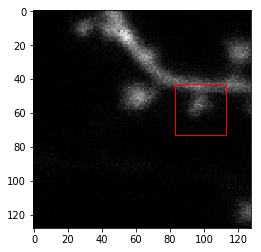

In [111]:
# preview image and single box using coordinates
fig,ax = plt.subplots(1)
ax.imshow(img_df.loc[0]['images'])
x_rect = img_df.loc[0]['x_y_coordinates'][0][0]-BOX_WIDTH/2
y_rect = img_df.loc[0]['x_y_coordinates'][1][0]-BOX_HEIGHT/2
rect = patches.Rectangle((x_rect,y_rect),BOX_WIDTH,BOX_HEIGHT,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [112]:
#Apply padding to all images and shift coordinates respectively
img_df = img_df.apply(pad_image_and_shift_coordinates, axis = 1)
img_df.loc[0]

img_path                   C:\Users\smirnovm\Documents\Data\Labeled_Spine...
info_path                  C:\Users\smirnovm\Documents\Data\Labeled_Spine...
ImageID                                                               000001
x_y_coordinates            [[98.0, 59.0, 120.0, 29.0], [58.0, 50.0, 26.0,...
images                     [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [5, 5, 5], ...
shape                                                          (128, 128, 3)
x_y_coordinates_shifted    [[140.0, 101.0, 162.0, 71.0], [116.0, 108.0, 8...
images_padded              [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
Name: 0, dtype: object

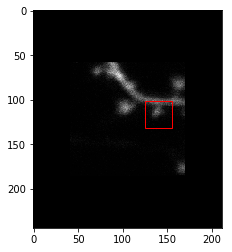

In [113]:
#preview image and single box using coordinates, after shifting has taken place
fig,ax = plt.subplots(1)
ax.imshow(img_df.loc[0]['images_padded'])
x_rect = img_df.loc[0]['x_y_coordinates_shifted'][0][0]-BOX_WIDTH/2
y_rect = img_df.loc[0]['x_y_coordinates_shifted'][1][0]-BOX_HEIGHT/2
rect = patches.Rectangle((x_rect,y_rect),BOX_WIDTH,BOX_HEIGHT,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [115]:
#map all coordinates to boxes
img_df['boxes'] = img_df['x_y_coordinates_shifted'].map(coords_to_boxes)
#preview dataframe
img_df.sample(2)

,img_path,info_path,ImageID,x_y_coordinates,images,shape,x_y_coordinates_shifted,images_padded,boxes
1689,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,001690,"[[62.0, 93.0, 94.0], [73.0, 75.0, 108.0]]","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(148, 146, 3)","[[95.0, 126.0, 127.0], [121.0, 123.0, 156.0]]","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[1.0, 80.0, 106.0, 110.0, 136.0], [1.0, 111.0..."
1257,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,001258,"[[55.0, 73.0, 88.0], [113.0, 81.0, 39.0]]","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(144, 132, 3)","[[95.0, 113.0, 128.0], [163.0, 131.0, 89.0]]","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[1.0, 80.0, 148.0, 110.0, 178.0], [1.0, 98.0,..."


In [116]:
# convert to array
images = img_df['images_padded'].as_matrix()
boxes = img_df['boxes'].as_matrix()
# save array
np.savez('spine_images_and_boxes',images = images,boxes = boxes)
# file can be loaded and accessed by 
# npzfile = np.load('spine_images_and_boxes.npz')
# npzfile['images']...

In [ ]:
# load sample underwater_data.npz to check what data should look like
# underwater_data = np.load('..//data//underwater_data.npz')

In [ ]:
# underwater_data['boxes'][50]

In [117]:
#save two samples for testing training algorithm
np.savez('spine_images_and_boxes_2_sample', images = images[220:222], boxes = boxes[220:222])

In [120]:
images[0].shape

(244, 212, 3)